In [3]:
import numpy as np
from scipy import io
import sys
import os
from ucrp import UniformConstantRebalancedPortfolio
from ubah import UniformBuyAndHoldPortfolio
from util import load_matlab_sp500_data
from expert_pool import ExpertPool
from olmar import OLMAR
from rmr import RMR
from nonparametric_markowitz import NonParametricMarkowitz
import matplotlib.pyplot as plt
%matplotlib inline

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [1]:
import matplotlib.patches as mpatches

x_range = range(0, numDays)
plt.plot(value_op_seq_npm, color='#25B009')
plt.plot(value_op_seq_rmr, color='red')
plt.plot(value_op_seq_pool, color='#9409B0')

pool_patch = mpatches.Patch(color='#9409B0', label='Pool')
npm_patch = mpatches.Patch(color='#25B009', label='Mark')
rmr_patch = mpatches.Patch(color='red', label='RMR')
#plt.legend(handles=[pool_patch, npm_patch, rmr_patch])
plt.legend(('Mark','RMR', 'Pool'), loc=(1.025,0.5))

plt.xlim([0, numDays])
plt.ylim([0.4, 3.5])
plt.xlabel("Day")
plt.ylabel("Value at Open (Dollars)")
plt.show()

NameError: name 'numDays' is not defined

In [49]:
# Load test data
directory = 'data/portfolio_train.mat'
test_data = load_matlab_sp500_data(directory)
num_days, numStocks = test_data.get_cl().shape
past_results_dir = 'train_results/' # Directory containing parameters learned during training
train_directory = 'data/portfolio_train.mat'
train_data = load_matlab_sp500_data(train_directory)

In [166]:
def get_results(portfolio):
    b_history = portfolio.b_history
    b_history = np.concatenate((b_history, np.reshape(portfolio.b, (-1,1))), axis=1)
    dollars_history = portfolio.get_dollars_history()
    return_seq = np.log(dollars_history[1:] / dollars_history[:-1])
    annual_return = 252 * np.mean(return_seq)
    sharpe = np.sqrt(252) * np.mean(return_seq) / np.std(return_seq)
    return b_history, dollars_history, annual_return, sharpe

In [25]:
def plot_dollars(dollars_li, colors=None, title=None, leg_titles=[], ylims=None):
    num_curves = len(dollars_li)
    if colors is None:
        colors = num_curves * ['blue']
    
    for c, dollars in zip(colors, dollars_li):
        plt.plot(dollars, color=c)

    num_days = len(dollars)
    plt.xlim([0, num_days])
    if ylims:
        plt.ylim(ylims)
    else:
        plt.ylim([0.4, 3.5])
    plt.xlabel("Day")
    plt.ylabel("Value at Open (Dollars)")
    
    if title:
        plt.title(title)
    
    if len(leg_titles) > 0:
        plt.legend((leg_titles), loc=(1.025,0.5))
    plt.show()

## Test Performance of UCRP Running Independently

------------------------------
Performance for uniform constant rebalancing portfolio:
------------------------------
Total dollar value of assets over time:
[ 1.          0.99950025  0.98491903  0.98303577  0.97991108  0.96248705
  0.95544509  0.96071265  0.9536129   0.9494757   0.94778775  0.96088634
  0.96767429  0.95241758  0.96392238  0.97762512  0.97949383  0.95940156
  0.95517422  0.94906216  0.94850635  0.94578973  0.92918602  0.91741894
  0.92352837  0.94842169  0.9450171   0.93384116  0.93215157  0.94543795]
Sharpe ratio:
0.351777130945
Final dollars:  1.63785287593
Annual Return:  0.0997859653614


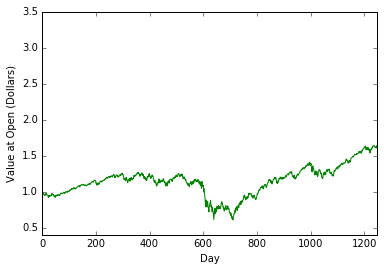

In [206]:
ucrp_ind = UniformConstantRebalancedPortfolio(market_data=test_data, tune_interval=None, verbose=True, 
                                         past_results_dir=past_results_dir+'UCRP/', repeat_past=True)
ucrp_ind.run()
ucrp_b_history, ucrp_dollars_history, ucrp_anret, ucrp_sharpe = get_results(ucrp_ind)
print 'Final dollars: ', str(ucrp_dollars_history[-1])
print 'Annual Return: ', str(ucrp_anret)
plot_dollars([ucrp_dollars_history], colors=['g'])

## Test Performance of RMR Running Independently

------------------------------
Performance for RMR:
------------------------------
Total dollar value of assets over time:
[ 1.          0.99950025  0.98489637  0.98292486  0.97975554  0.96241748
  0.95539376  0.9606766   0.9534517   0.94931196  0.94756174  0.96060426
  0.9674525   0.95214194  0.96370193  0.97726923  0.97910693  0.95881915
  0.95452157  0.9484951   0.94785802  0.94511495  0.92860544  0.91684588
  0.92296297  0.94781949  0.94442791  0.93324024  0.93147986  0.94471015]
Sharpe ratio:
1.22844849375
Final dollars:  1.67169787725
Annual Return:  0.103922656769


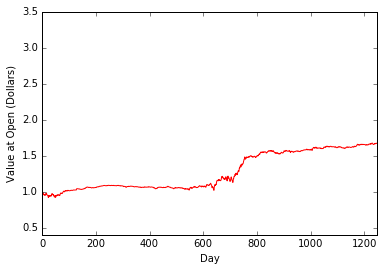

In [205]:
rmr_ind = RMR(market_data=test_data, market_data_train=train_data, tune_interval=60, verbose=True, past_results_dir=past_results_dir+'RMR/', repeat_past=True)
rmr_ind.run()
rmr_b_history, rmr_dollars_history, rmr_anret, rmr_sharpe = get_results(rmr_ind)
print 'Final dollars: ', str(rmr_dollars_history[-1])
print 'Annual Return: ', str(rmr_anret)
plot_dollars([rmr_dollars_history], colors=['r'])

## OLMAR Running Independently

------------------------------
Performance for OLMAR:
------------------------------
Total dollar value of assets over time:
[ 1.          0.99950025  0.98418182  0.97931132  0.97930989  0.97263032
  0.96674497  0.96585503  0.95815581  0.96497329  0.95859295  0.96687961
  0.97133383  0.96713105  0.96843645  0.97256705  0.97041027  0.97175164
  0.97138592  0.96969478  0.9673426   0.96483505  0.956596    0.94974345
  0.96302584  0.97925651  0.97666715  0.9754731   0.97511963  0.97537369]
Sharpe ratio:
0.573193806125
Final dollars:  1.45471806897
Annual Return:  0.0758046973781


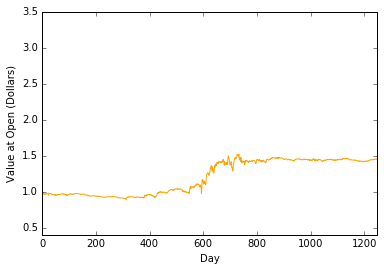

In [204]:
olmar_ind = OLMAR(market_data=test_data, market_data_train=train_data, tune_interval=20, verbose=True, past_results_dir=past_results_dir+'OLMAR/', repeat_past=True) 
olmar_ind.run()
olmar_b_history, olmar_dollars_history, olmar_anret, olmar_sharpe = get_results(olmar_ind)
print 'Final dollars: ', str(olmar_dollars_history[-1])
print 'Annual Return: ', str(olmar_anret)
plot_dollars([olmar_dollars_history], colors=['orange'])

## Test Performance of NPM Independently

------------------------------
Performance for Nonparametric Markowitz Portfolio:
------------------------------
Sharpe ratio:
0.256346909504
Final dollars:  2.10815429663
Annual Return:  0.150838548622


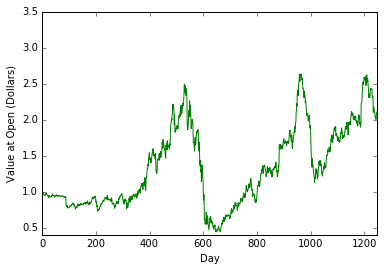

In [202]:
npm_ind = NonParametricMarkowitz(market_data=test_data, market_data_train=train_data, tune_interval=None, verbose=True, past_results_dir=past_results_dir+'NPM/', repeat_past=True)
npm_ind.run()
npm_b_history, npm_dollars_history, npm_anret, npm_sharpe = get_results(npm_ind)
print 'Final dollars: ', str(npm_dollars_history[-1])
print 'Annual Return: ', str(npm_anret)
plot_dollars([npm_dollars_history], colors=['g'])

------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
Total dollar value of assets over time:
[ 1.          0.99950025  0.98476035  0.98136635  0.97822916  0.96014496
  0.95264874  0.95781759  0.94998201  0.94676616  0.94423578  0.95842386
  0.96686177  0.95140856  0.96259433  0.97656712  0.97737666  0.95838134
  0.95418673  0.94779409  0.94585307  0.94209601  0.92208468  0.90716588
  0.91670746  0.94503323  0.94051593  0.93466544  0.93345106  0.93990226]
Sharpe ratio:
0.833701947644
Final dollars:  3.21459069965
Annual Return:  0.236164053032


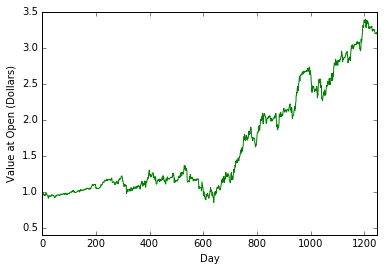

In [203]:
# Test Performance of Expert Pool
ucrp = UniformConstantRebalancedPortfolio(market_data=test_data, tune_interval=None, verbose=True, 
                                         past_results_dir=past_results_dir+'UCRP/', repeat_past=True)
olmar = OLMAR(market_data=test_data, market_data_train=train_data, tune_interval=20, verbose=True, 
              past_results_dir=past_results_dir+'OLMAR/', repeat_past=True) 
rmr = RMR(market_data=test_data, market_data_train=train_data, tune_interval=60, verbose=True, 
          past_results_dir=past_results_dir+'RMR/', repeat_past=True)
npm = NonParametricMarkowitz(market_data=test_data, market_data_train=train_data, tune_interval=None, 
                             verbose=True, past_results_dir=past_results_dir+'NPM/', repeat_past=True)
pool = ExpertPool(market_data=test_data, experts=[ucrp, olmar, rmr, npm], verbose=True, ew_eta=0.2, windows=[10]) 
pool.run()

pool_b_history, pool_dollars_history, pool_anret, pool_sharpe = get_results(pool)
print 'Final dollars: ', str(pool_dollars_history[-1])
print 'Annual Return: ', str(pool_anret)
plot_dollars([pool_dollars_history], colors=['g'])
weights_history = pool.weights_history

## Plot All Experts For Comparison

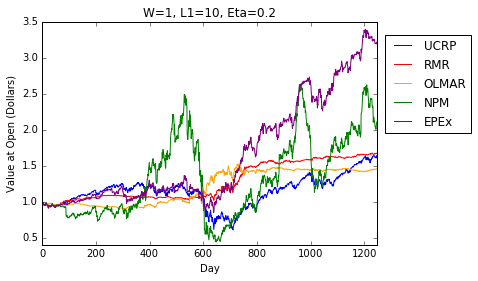

In [209]:
plot_dollars([ucrp_dollars_history, rmr_dollars_history, 
              olmar_dollars_history, npm_dollars_history, pool_dollars_history], 
             colors=['b', 'r', 'orange', 'g', 'purple'], 
             leg_titles=['UCRP','RMR', 'OLMAR','NPM','EPEx'],
            title='W=1, L1=10, Eta=0.2')

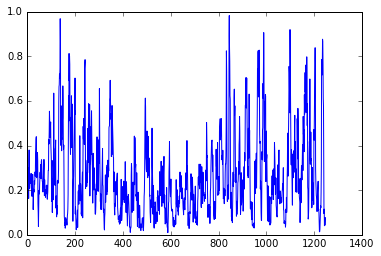

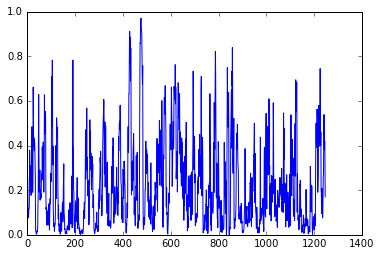

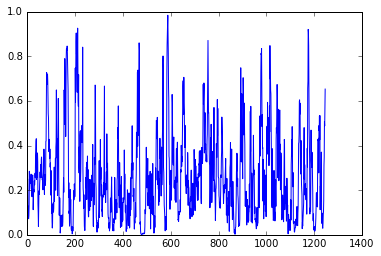

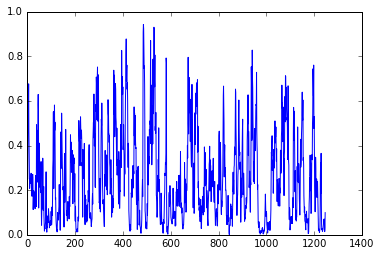

"\nplt.bar(range(0, numDays),weights_history[:,3], color='blue')\nplt.xlim([0,numDays])\nplt.show()\n"

In [239]:
plt.plot(weights_history[:,0])
plt.show()

plt.plot(weights_history[:,1])
plt.show()

plt.plot(weights_history[:,2])
plt.show()

plt.plot(weights_history[:,3])
plt.show()
"""
plt.bar(range(0, numDays),weights_history[:,3], color='blue')
plt.xlim([0,numDays])
plt.show()
"""

## Experiment With Different Eta

## Plot Effect of Eta. X-axis is increasing threshold (a fraction), and y-axis is fraction of days that have a single weight greater than the threshold. Plot one curve for each value of eta you sweep (go from 0.1 to 10 or something) 

In [212]:
eta_range = np.arange(0.1, 1.1, 0.1)
eta_range = np.append(eta_range, 3.0)
eta_range = np.append(eta_range, 5.0)
eta_range = np.append(eta_range, 10.0)
pools = []
num_experts = 4
num_days = test_data.get_cl().shape[0]
weights_histories = np.zeros(shape=(len(eta_range), num_days, num_experts))
for (i, eta) in enumerate(eta_range):
    ucrp = UniformConstantRebalancedPortfolio(market_data=test_data, tune_interval=None, verbose=True, 
                                         past_results_dir=past_results_dir+'UCRP/', repeat_past=True)
    olmar = OLMAR(market_data=test_data, market_data_train=train_data, tune_interval=20, verbose=True, 
                  past_results_dir=past_results_dir+'OLMAR/', repeat_past=True) 
    rmr = RMR(market_data=test_data, market_data_train=train_data, tune_interval=60, verbose=True, 
              past_results_dir=past_results_dir+'RMR/', repeat_past=True)
    npm = NonParametricMarkowitz(market_data=test_data, market_data_train=train_data, tune_interval=None, 
                                 verbose=True, past_results_dir=past_results_dir+'NPM/', repeat_past=True)
    pools.append(ExpertPool(market_data=test_data, 
                            experts=[ucrp, olmar, rmr, npm], 
                            verbose=False, silent=True, ew_eta=eta, windows=[10])) 
    pools[i].run()
    weights_histories[i,:,:] = pools[i].weights_history
    #pool_b_history, pool_dollars_history, pool_anret, pool_sharpe = get_results(pool)
    #plot_dollars([pool_dollars_history], colors=['g'])

------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------

In [299]:
thresholds = np.arange(0.2,1.025,0.025)
thresholds[-1] = 1.0  # avoids an issue with numpy where it treats 1.0 differently

# Array storing fraction of days exceeding different threshold for each
# (eta, threshold) pair
eta_effect = np.zeros((len(eta_range), len(thresholds)))

for i,eta in enumerate(eta_range):
    cur_weights_history = weights_histories[i]
    for j, thresh in enumerate(thresholds):
        num_greater = 0  # Number of days where at least 1 weight exceeds thresh
        for weights in cur_weights_history:
            # Count how many weights are given than each threshold
            num_greater += 1.0 * int(np.max(weights) >= thresh)
        eta_effect[i, j] = num_greater / num_days

In [300]:
def plot_eta_effect(eta_effect_arr, thresholds, eta_range, 
                    colors=['r','blue', 'g'], leg_labels=[], num_leg_cols=1):
    if len(colors) < len(eta_range):
        colors = len(eta_range) * ['blue']
    cmap = plt.cm.jet
    min_eta = int(0)
    max_eta = int(len(eta_range)-1)

    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_eta, vmax=max_eta))
    plt.figure(figsize=(7,5))
    for i, (frac_greater, eta, col) in enumerate(zip(eta_effect_arr, eta_range, colors)):
        colorVal = scalarMap.to_rgba(i)
        plt.plot(thresholds, frac_greater, color=colorVal)
        
    if len(leg_labels) > 0:
        legend = plt.legend((leg_labels), loc=(0.0,-0.5), title='Eta', ncol=num_leg_cols)
        legend.get_title().set_fontsize('12')
    plt.xlim([thresholds[0], 1.0])
    plt.xlabel('Threshold', size=12)
    plt.ylabel('Fraction of Days', size=12)
    plt.show()

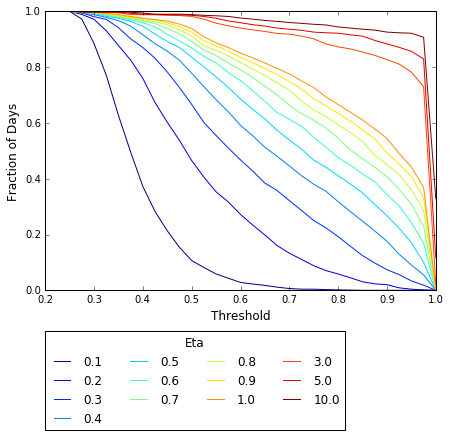

In [301]:
plot_eta_effect(eta_effect, thresholds, eta_range, leg_labels=[str(eta) for eta in eta_range], num_leg_cols=4)

In [302]:
print thresholds
print eta_effect[-1]

[ 0.2    0.225  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425
  0.45   0.475  0.5    0.525  0.55   0.575  0.6    0.625  0.65   0.675  0.7
  0.725  0.75   0.775  0.8    0.825  0.85   0.875  0.9    0.925  0.95
  0.975  1.   ]
[ 1.          1.          1.          0.99759423  0.99759423  0.99759423
  0.99759423  0.9967923   0.9935846   0.98957498  0.98957498  0.98957498
  0.98797113  0.98556536  0.98396151  0.98155573  0.97594226  0.97193264
  0.96712109  0.96391339  0.95990377  0.95669607  0.95348837  0.9510826
  0.94386528  0.93985565  0.93584603  0.93263833  0.92542101  0.92301524
  0.92141139  0.90697674  0.32798717]


## Experiment with Different Window Configurations

In [295]:
def plot_window_results(pool_dollars_histories_w, window_configs, ylims=None, 
                        title=None, num_legend_cols=3, legend_title=None, legend_loc='below', cmap=True):
    num_curves = pool_dollars_histories_w.shape[0]
    num_days = pool_dollars_histories_w.shape[1]
    
    cmap = plt.cm.gist_rainbow
    min_val = int(0)
    max_val = num_curves-1
    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_val, vmax=max_val))
        
    for i, dollars in enumerate(pool_dollars_histories_w):
        colorVal = scalarMap.to_rgba(i)
        plt.plot(dollars, color=colorVal)
    #for c, dollars in zip(colors, dollars_li):
    #    plt.plot(dollars, color=c)

    num_days = len(dollars)
    plt.xlim([0, num_days])
    if ylims:
        plt.ylim(ylims)
    else:
        plt.ylim([0.5, 4.0])
    plt.xlabel("Day")
    plt.ylabel("Value at Open (Dollars)")
    
    if title:
        plt.title(title)
    
    legend_labels = []
    for w in window_configs:
        if w[0] > num_days:
            legend_labels.append('All')
        else:
            legend_labels.append(','.join([str(val) for val in w]))
    #plt.legend((legend_labels), loc=(1.025,0.5))
    if legend_title is None:
        legend_title = 'Window Configs'
    
    if legend_loc == 'below':
        loc = (0.0, -0.5)
    else:
        loc = (1.025, 0.3)
    legend = plt.legend((legend_labels), loc=loc, title=legend_title, ncol=num_legend_cols)
    legend.get_title().set_fontsize('12')
    plt.show()

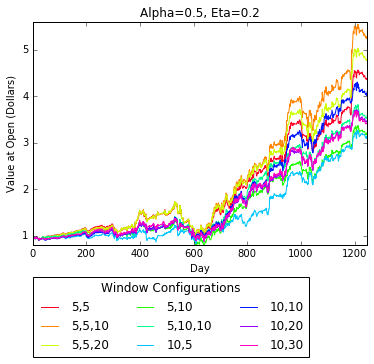

In [296]:
plot_window_results(pool_dollars_histories_wc, window_configs, title='Alpha=0.5, Eta=0.2', ylims=[0.8,5.6],
                    legend_title='Window Configurations', num_legend_cols=3, legend_loc='below', cmap=True)

In [154]:
window_lengths = [[4],[5]]
for w in np.arange(10, 40, 20):
    window_lengths.append([w])
window_lengths.append([100])
window_lengths.append([200])
window_lengths.append([1250])
    
num_lengths = len(window_lengths)
sharpes_w = np.zeros(num_lengths)
anret_w = np.zeros(num_lengths)
pool_dollars_histories_w = np.zeros(shape=(num_lengths,num_days))
#eta_range = np.append(eta_range, 3.0)

for (i, windows) in enumerate(window_lengths):
    ucrp = UniformConstantRebalancedPortfolio(market_data=test_data, tune_interval=None, verbose=True, 
                                             past_results_dir=past_results_dir+'UCRP/', repeat_past=True)
    olmar = OLMAR(market_data=test_data, market_data_train=train_data, tune_interval=20, verbose=True, 
                  past_results_dir=past_results_dir+'OLMAR/', repeat_past=True) 
    rmr = RMR(market_data=test_data, market_data_train=train_data, tune_interval=60, verbose=True, 
              past_results_dir=past_results_dir+'RMR/', repeat_past=True)
    npm = NonParametricMarkowitz(market_data=test_data, market_data_train=train_data, tune_interval=None, 
                                 verbose=True, past_results_dir=past_results_dir+'NPM/', repeat_past=True)
    pool = ExpertPool(market_data=test_data, experts=[ucrp, olmar, rmr, npm],
                      verbose=False, silent=True, ew_eta=0.2, windows=windows) 
    pool.run()

    pool_b_history, pool_dollars_history, pool_anret, pool_sharpe = get_results(pool)
    pool_dollars_histories_w[i] = pool_dollars_history
    anret_w[i] = pool_anret
    sharpes_w[i] = pool_sharpe

------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window


## W=1 (Single Window), Varying Window Lengths

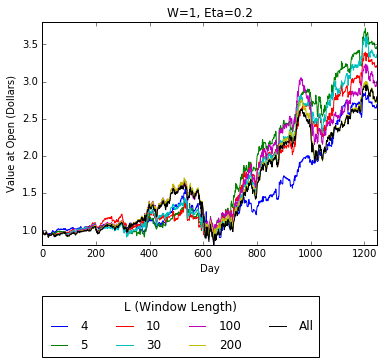

In [208]:
plot_window_results(pool_dollars_histories_w, window_lengths, ylims=[0.8, 3.8], title='W=1, Eta=0.2', 
                    legend_title='L (Window Length)', num_legend_cols=4, legend_loc='below')

## Use Various Window Configurations

In [196]:
window_configs = [[5, 5], [5, 5, 10], [5, 5, 20], [5, 10], [5, 10, 10], [10, 5], [10,10], [10, 20], [10, 30]]
num_configs = len(window_configs)
sharpes_wc = np.zeros(num_configs)
anret_wc = np.zeros(num_configs)
pool_dollars_histories_wc = np.zeros(shape=(num_configs,num_days))
#eta_range = np.append(eta_range, 3.0)

for (i, windows) in enumerate(window_configs):
    ucrp = UniformConstantRebalancedPortfolio(market_data=test_data, tune_interval=None, verbose=True, 
                                             past_results_dir=past_results_dir+'UCRP/', repeat_past=True)
    olmar = OLMAR(market_data=test_data, market_data_train=train_data, tune_interval=20, verbose=True, 
                  past_results_dir=past_results_dir+'OLMAR/', repeat_past=True) 
    rmr = RMR(market_data=test_data, market_data_train=train_data, tune_interval=60, verbose=True, 
              past_results_dir=past_results_dir+'RMR/', repeat_past=True)
    npm = NonParametricMarkowitz(market_data=test_data, market_data_train=train_data, tune_interval=None, 
                                 verbose=True, past_results_dir=past_results_dir+'NPM/', repeat_past=True)
    pool = ExpertPool(market_data=test_data, experts=[ucrp, olmar, rmr, npm],
                      verbose=False, silent=True, ew_eta=0.2, windows=windows) 
    pool.run()

    pool_b_history, pool_dollars_history, pool_anret, pool_sharpe = get_results(pool)
    pool_dollars_histories_wc[i] = pool_dollars_history
    anret_wc[i] = pool_anret
    sharpes_wc[i] = pool_sharpe

------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------------
Results of expert pooling: 
------------------------------
Weighting strategy:  exp_window
------------------------

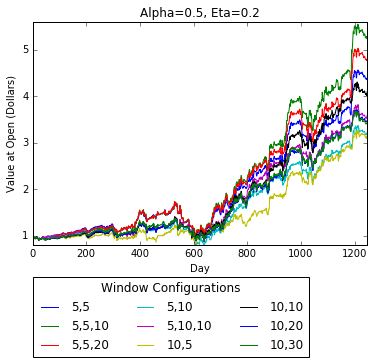

In [199]:
plot_window_results(pool_dollars_histories_wc, window_configs, title='Alpha=0.5, Eta=0.2', ylims=[0.8,5.6],
                    legend_title='Window Configurations', num_legend_cols=3, legend_loc='below')

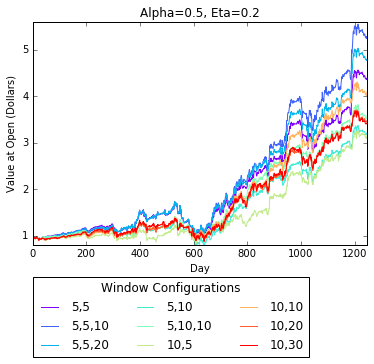

In [288]:
plot_window_results(pool_dollars_histories_wc, window_configs, title='Alpha=0.5, Eta=0.2', ylims=[0.8,5.6],
                    legend_title='Window Configurations', num_legend_cols=3, legend_loc='below', cmap=True)